I want to integrate classical methods to optimize hyperparameters from quantum world.

In [ ]:
# Install Qiskit Dynamics
!pip install qiskit-dynamics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.models import LindbladModel
from qiskit.quantum_info import Operator, Statevector, DensityMatrix, Pauli
import matplotlib.pyplot as plt


In [ ]:
N = 6  # Number of qubits
omega_z = 2 * np.pi * 5e9  # Qubit frequency in rad/s (5 GHz)
omega_x = 2 * np.pi * 0.5e9  # Drive frequency in rad/s (0.5 GHz)
J = 2 * np.pi * 0.2e9  # Coupling strength in rad/s (0.2 GHz)
Gamma = 2 * np.pi * 1e6  # Dissipation rate in rad/s (1 MHz)
#initializing the operators X,Y, Z
x_ops = []
y_ops = []
z_ops = []
qubits = range(N)
zeros = Operator(np.zeros((2 ** N, 2 ** N)))

for i in qubits:
    X = zeros + Pauli('X')(i)
    x_ops.append(X)

    Y = zeros + Pauli('Y')(i)
    y_ops.append(Y)

    Z = zeros + Pauli('Z')(i)
    z_ops.append(Z)

In [ ]:
H = zeros
for i in qubits:
    X = x_ops[i]
    Z = z_ops[i]
    H += 0.5 * omega_x * X  # Driving term
    H += 0.5 * omega_z * Z  # Qubit energy term

    if N > 1:
        j = i + 1 if i < (N - 1) else 0
        op_xx = zeros + Pauli('XX')(i, j)
        op_yy = zeros + Pauli('YY')(i, j)
        H += 0.5 * J * (op_xx + op_yy)  # Interaction terms

In [ ]:
# THE Lindblad operators (decay process)
L_ops = []
for i in qubits:
    X = x_ops[i]
    Y = y_ops[i]
    L_ops.append(np.sqrt(Gamma) * 0.5 * (X + 1j * Y))

In [ ]:
solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)

# all qubits in ground state
y0 = DensityMatrix.from_label('0' * N)

t_final = 2.0e-6  # Total simulation time (e.g., 2 microseconds)
tau = 0.01e-6  # Time step (10 ns)
n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

# Solve the Lindblad equation
sol = solver.solve(t_span=[0., t_final], y0=y0, t_eval=t_eval)

In [ ]:
# Calculate expectation values
n_times = len(sol.y)
x_data = np.zeros((N, n_times))
y_data = np.zeros((N, n_times))
z_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))
y_mean = np.zeros((n_times,))
z_mean = np.zeros((n_times,))

for t_i, sol_t in enumerate(sol.y):
    for qubit, obs in enumerate(x_ops):
        x_data[qubit, t_i] = sol_t.expectation_value(obs).real
    x_mean[t_i] = np.mean(x_data[:, t_i])

    for qubit, obs in enumerate(y_ops):
        y_data[qubit, t_i] = sol_t.expectation_value(obs).real
    y_mean[t_i] = np.mean(y_data[:, t_i])

    for qubit, obs in enumerate(z_ops):
        z_data[qubit, t_i] = sol_t.expectation_value(obs).real
    z_mean[t_i] = np.mean(z_data[:, t_i])

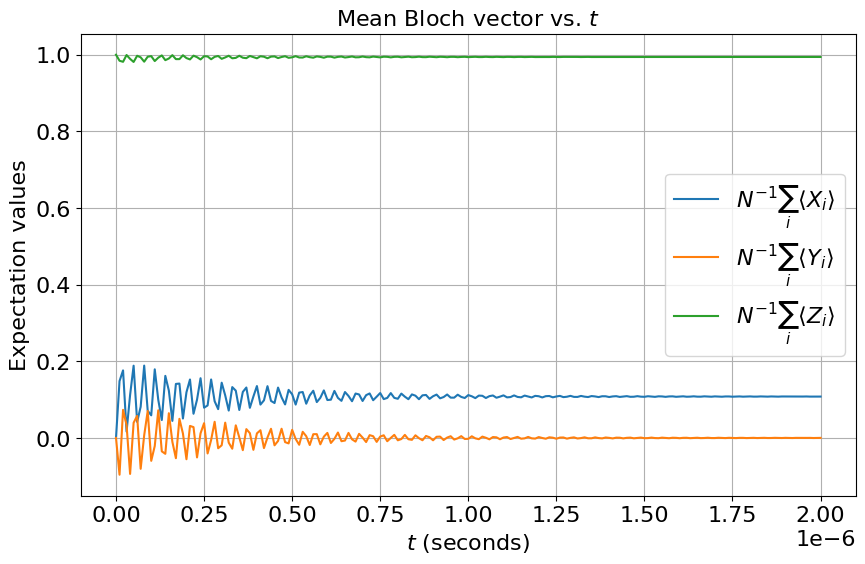

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_eval, x_mean, label='$ N^{-1}\\sum_i \\langle X_i \\rangle$')
plt.plot(t_eval, y_mean, label='$ N^{-1}\\sum_i \\langle Y_i \\rangle$')
plt.plot(t_eval, z_mean, label='$ N^{-1}\\sum_i \\langle Z_i \\rangle$')
plt.legend(fontsize=16)
plt.xlabel('$t$ (seconds)', fontsize=16)
plt.ylabel('Expectation values', fontsize=16)
plt.title('Mean Bloch vector vs. $t$', fontsize=16)
plt.grid(True)
plt.show()

OPTIMIZATION - CONCEPTUAL ALGORITHM

In [ ]:
import numpy as np

class QuantumOptimizer:
    def __init__(self, objective_function, search_space, n_trials=100):
        """
        A basic optimizer for Quantum Machine Learning.

        Parameters:
        - objective_function: A callable function to minimize or maximize.
        - search_space: A dictionary defining parameter ranges, e.g., {'param1': (min, max)}.
        - n_trials: Number of optimization trials to run.
        """
        self.objective_function = objective_function
        self.search_space = search_space
        self.n_trials = n_trials
        self.best_params = None
        self.best_value = float('inf')

    def sample_parameters(self):
        """Randomly samples parameters from the search space."""
        return {key: np.random.uniform(low, high) for key, (low, high) in self.search_space.items()}

    def optimize(self):
        """Run the optimization loop."""
        for trial in range(self.n_trials):
            params = self.sample_parameters()
            value = self.objective_function(params)

            if self.best_value is None or value < self.best_value:
                self.best_value = value
                self.best_params = params

            print(f"Trial {trial+1}/{self.n_trials}: Value = {value}, Params = {params}")

        print(f"\nBest Value: {self.best_value}")
        print(f"Best Parameters: {self.best_params}")
        return self.best_params, self.best_value


In [ ]:
from qiskit_dynamics import Solver
from qiskit.quantum_info import DensityMatrix

def lindblad_objective(params):
    """
    Objective function for optimizing Lindblad equation parameters.

    Parameters:
    - params: Dictionary containing parameters such as {'omega_x': value, 'omega_z': value, 'gamma': value}

    Returns:
    - A metric to minimize, e.g., the deviation from a target state or minimized energy.
    """
    omega_x = params['omega_x']
    omega_z = params['omega_z']
    J = params['J']
    Gamma = params['Gamma']

    # single qubit example
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    H = 0.5 * (omega_x * sigma_x + omega_z * sigma_z)
    L_ops = [np.sqrt(Gamma) * sigma_x]

    solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)

    y0 = DensityMatrix.from_label('0')

    t_final = 1e-6
    t_eval = np.linspace(0., t_final, 100)


    solution = solver.solve(t_span=[0., t_final], y0=y0, t_eval=t_eval)


    final_state = solution.y[-1]
    target_state = DensityMatrix.from_label('0')
    fidelity = abs((final_state.data.conj().T @ target_state.data).trace())

    # Metric to minimize - INFIDELITY
    return 1 - fidelity


In [ ]:
search_space = {
    'omega_x': (0, 2 * np.pi * 1e9),  # Range of omega_x (0 to 1 GHz)
    'omega_z': (0, 2 * np.pi * 1e9),  # Range of omega_z (0 to 1 GHz)
    'J': (0, 2 * np.pi * 0.5e9),      # Coupling strength (0 to 0.5 GHz)
    'Gamma': (0, 2 * np.pi * 5e6)     # Dissipation rate (0 to 5 MHz)
}

optimizer = QuantumOptimizer(objective_function=lindblad_objective, search_space=search_space, n_trials=20)

best_params, best_value = optimizer.optimize()


Trial 1/20: Value = 0.4999999439269466, Params = {'omega_x': 1753150639.7281978, 'omega_z': 4755638476.171682, 'J': 1131402911.5776303, 'Gamma': 29258131.485337514}
Trial 2/20: Value = 0.499999921850973, Params = {'omega_x': 3120930147.4125805, 'omega_z': 6114282813.843698, 'J': 1270397162.3362384, 'Gamma': 25369535.70487496}
Trial 3/20: Value = 0.4999997337281177, Params = {'omega_x': 2515150163.2333703, 'omega_z': 2982123088.494198, 'J': 1174261406.2610922, 'Gamma': 23331349.78084315}
Trial 4/20: Value = 0.49679936337370634, Params = {'omega_x': 6059733842.915726, 'omega_z': 1518751323.7498736, 'J': 715331869.919359, 'Gamma': 18796591.919982325}
Trial 5/20: Value = 0.5000001282357438, Params = {'omega_x': 6114380520.742224, 'omega_z': 3908713090.9119334, 'J': 202517622.89389434, 'Gamma': 30969115.490311082}
Trial 6/20: Value = 0.497803681417046, Params = {'omega_x': 5238538336.562709, 'omega_z': 397702050.29471606, 'J': 3113300214.47251, 'Gamma': 20143849.02078758}
Trial 7/20: Value 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data from the optimization trials
data = {
    "Trial": np.arange(1, 21),
    "omega_x": [
        1753150639.7281978, 3120930147.4125805, 2515150163.2333703, 6059733842.915726, 6114380520.742224,
        5238538336.562709, 5819517586.512424, 2940712606.426972, 5716454990.004161, 2380638742.3289924,
        788078297.1090487, 3058628175.2245164, 4858059727.584334, 4090270974.4971213, 4057467747.601433,
        1856805714.7254143, 3431986080.5105934, 3378530744.014591, 2766678609.6271114, 2968620781.691315
    ],
    "omega_z": [
        4755638476.171682, 6114282813.843698, 2982123088.494198, 1518751323.7498736, 3908713090.9119334,
        397702050.29471606, 5518302336.801193, 4013803664.0051107, 2324024519.7243476, 1744113676.5173151,
        248491604.43262723, 3089664343.4196463, 1214715053.944431, 3482676662.7526155, 2776496207.777498,
        2411160562.9478035, 4224172014.2055073, 1132192696.586007, 3819195505.494021, 4223703631.7021937
    ],
    "J": [
        1131402911.5776303, 1270397162.3362384, 1174261406.2610922, 715331869.919359, 202517622.89389434,
        3113300214.47251, 1400992597.3983471, 2825750301.5795865, 1661459552.162021, 938756087.6692988,
        540063183.958555, 2222382106.846115, 2653507148.2983737, 1400226139.9591854, 2934946505.2931156,
        710600316.7228822, 662698941.5402639, 2310574894.029198, 2420740804.552356, 359499996.51622385
    ],
    "Gamma": [
        29258131.485337514, 25369535.70487496, 23331349.78084315, 18796591.919982325, 30969115.490311082,
        20143849.02078758, 16817474.820458997, 5401835.062948424, 10406789.549261203, 5042085.784450411,
        27113726.401106644, 29393525.611028194, 20253326.01250351, 29074969.359786972, 15169699.806705961,
        5584950.034317046, 10256787.58415841, 28046590.138056632, 14620456.332000218, 7697699.860659273
    ],
    "Infidelity": [
        0.4999999439269466, 0.499999921850973, 0.4999997337281177, 0.49679936337370634, 0.5000001282357438,
        0.497803681417046, 0.5000000954155583, 0.4996974129406996, 0.49629840340210996, 0.4948413476344611,
        0.49966106754744166, 0.4999998488097269, 0.4972858706240403, 0.5000001243817416, 0.4999900003104025,
        0.499727487350231, 0.4999985163057903, 0.4998245147637915, 0.5000001036297417, 0.499988700660165
    ]
}

df = pd.DataFrame(data)

df_normalized = df.copy()
df_normalized['omega_x'] = (df['omega_x'] - df['omega_x'].min()) / (df['omega_x'].max() - df['omega_x'].min())
df_normalized['omega_z'] = (df['omega_z'] - df['omega_z'].min()) / (df['omega_z'].max() - df['omega_z'].min())
df_normalized['J'] = (df['J'] - df['J'].min()) / (df['J'].max() - df['J'].min())
df_normalized['Gamma'] = (df['Gamma'] - df['Gamma'].min()) / (df['Gamma'].max() - df['Gamma'].min())


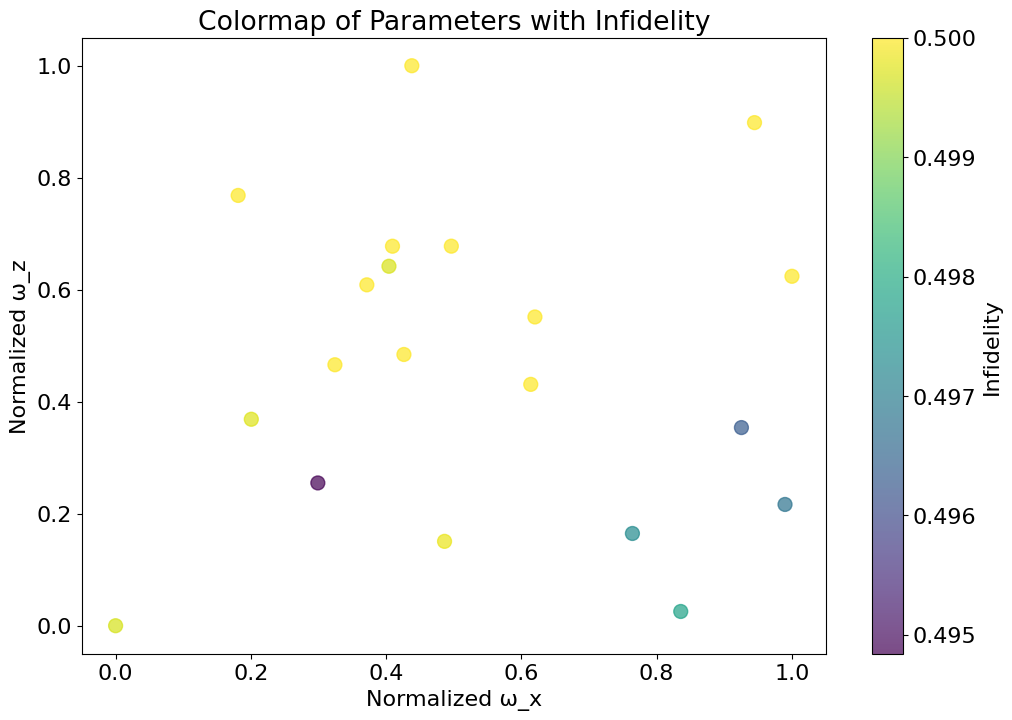

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

sc = ax.scatter(df_normalized['omega_x'], df_normalized['omega_z'],
                c=df['Infidelity'], cmap='viridis', s=100, alpha=0.7, label='Infidelity')

cbar = plt.colorbar(sc, ax=ax, label='Infidelity')

# Label axes
ax.set_xlabel('Normalized ω_x')
ax.set_ylabel('Normalized ω_z')
ax.set_title('Colormap of Parameters with Infidelity')


plt.show()
